In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
from keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import missingno as msno
import seaborn as sn
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Only required for when model used is neural Network
def build_model(s):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(s,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [20]:
# Validation to fine tune parameters.
def validate_model(train_data, train_labels):
    k = 5
    num_val_samples = len(train_data)//k
    depth_list = [5,10,15,20]
    val_acc = np.array([0]*len(depth_list)).astype('float32')
    train_acc = np.array([0]*len(depth_list)).astype('float32')

    for i in range(k):
        print('processing fold #', i)
        val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
        
        val_labels = train_labels[i * num_val_samples: (i+1) * num_val_samples]
        partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:]], axis=0)
        partial_train_labels = np.concatenate([train_labels[:i * num_val_samples], train_labels[(i+1) * num_val_samples:]], axis=0)
        temp_val_acc = [0]*len(depth_list)
        temp_train_acc = [0]*len(depth_list)
        for i in range(len(depth_list)):
            model = BaggingClassifier(n_estimators=depth_list[i],max_samples=0.3,max_features=0.5)
            model.fit(partial_train_data, partial_train_labels)
            temp_val_acc[i] = accuracy_score(val_labels,model.predict(val_data))
            temp_train_acc[i] = accuracy_score(partial_train_labels,model.predict(partial_train_data))
        val_acc += np.array(temp_val_acc)
        train_acc += np.array(temp_train_acc)
    fig, ax=plt.subplots()
    ax.plot(depth_list, list(val_acc/k), label='val_acc',color='red',)
    ax.plot(depth_list, list(train_acc/k), label='train_acc',color='blue')
    ax.legend()
    ax.set_xticks(depth_list)
    ax.set_xticklabels([str(i) for i in depth_list])
    plt.title('Bagging- number of estimators')
    plt.xlabel('num estimators')
    plt.ylabel('Accuracy')
    plt.show()

In [4]:
# Reading Data
data = pd.read_csv("3year.csv", na_values='?').values
# Writing Columns for later, we need to convert to dataframe
col = []
for i in range(1,data.shape[1]):
    col = col + ['X'+str(i)]
print(col)

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64']


IMPUTATION

In [5]:
imputer_simple = SimpleImputer(missing_values=np.nan, strategy='mean')
mean_imputed_data = imputer_simple.fit_transform(data)

In [6]:
imputer_knn = KNNImputer(n_neighbors=50)
knn_imputed_data = imputer_knn.fit_transform(data)

TRAIN-TEST SPLIT

In [7]:
# Train and test are seperated. Train will be deat with, test remains untouched
a = [0 for i in range(4)]
b = [0 for i in range(4)]
a[0], a[1], b[0], b[1] = train_test_split(scale(mean_imputed_data[:,:-1]), mean_imputed_data[:,-1], test_size=0.15, random_state=0);
a[2], a[3], b[2], b[3] = train_test_split(scale(knn_imputed_data[:,:-1]), knn_imputed_data[:,-1], test_size=0.15, random_state=0);
print(type(a[1]))

<class 'numpy.ndarray'>


OVERSAMPING

In [8]:
# Oversampling train data from both imputations
sm = SMOTE(random_state=0)
xm, ym = sm.fit_resample(a[0],b[0])
xk, yk = sm.fit_resample(a[2],b[2])
print(a[0].shape,xm.shape)
print('Resampled dataset shape %s, %s' % (Counter(ym),Counter(b[0])))

(8927, 64) (17004, 64)
Resampled dataset shape Counter({0.0: 8502, 1.0: 8502}), Counter({0.0: 8502, 1.0: 425})


FEATURE SELECTION:
1) EDA

In [9]:
# returns set of deleted features ie. those which are very correlated
def EDA(corr):
    deleted = set()
    for i in range(1,65):
        if i in deleted:
            continue
        temp_list = [corr['X'+str(i)] >= 0.95]
        for j in range(i+1,65):
            if temp_list[0][j-1] and j not in deleted:
                deleted.add(j)
    return deleted

20


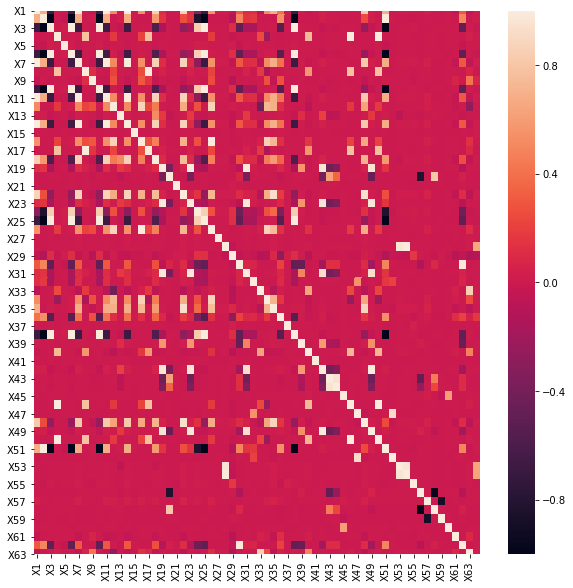

In [10]:
# calculating correlations and printing number of removed features
corr0 = pd.DataFrame(xm,columns=col).corr()
plt.figure(figsize = (10,10))
corr0.style.background_gradient(cmap='coolwarm').set_precision(4)
ax = sn.heatmap(corr0)
eda_features_mean = EDA(pd.DataFrame(corr0))

print(len(eda_features_mean))

20


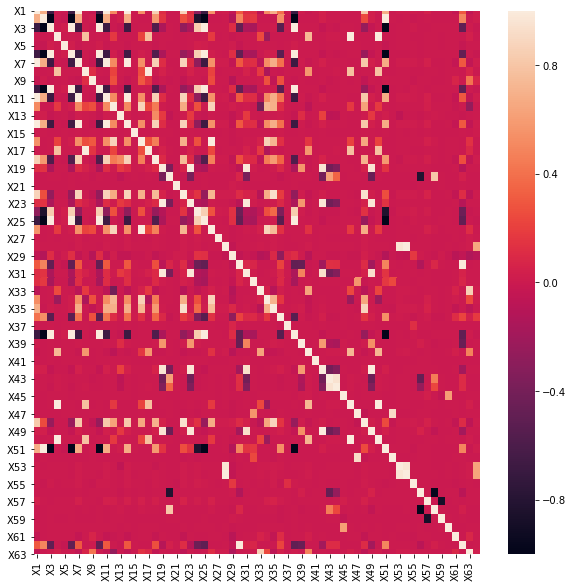

In [11]:
corr1 = pd.DataFrame(xk,columns=col).corr()
plt.figure(figsize = (10,10))
corr1.style.background_gradient(cmap='coolwarm').set_precision(4)
ax = sn.heatmap(corr1)
eda_features_knn = EDA(pd.DataFrame(corr1))
print(len(eda_features_knn))

FEATURE SELECTION 2) RFECV

In [12]:
# return and RFECV type object which is further used to transform training adn test sets
def RFE1(train,test):
    model = LogisticRegression(max_iter=50000)
    rfecv = RFECV(model, step = 2, min_features_to_select=32)
    rfecv = rfecv.fit(train,test)
    return rfecv
rfecvmean = RFE1(xm,ym)
print('half')
rfecvknn = RFE1(xk,yk)

half


OUTLIER REMOVAL

In [13]:
# FEATURE REDUCTION AND OUTLIER REMOVAL for the 4 training sets

xmr = rfecvmean.transform(xm) # feature selection using rfecv for mean data
zmr = np.abs(stats.zscore(xmr)) 
xmr = xmr[(zmr < 2).all(axis=1)] # outlier removal
ymr = ym[(zmr < 2).all(axis=1)]

xkr = rfecvknn.transform(xk)
zkr = np.abs(stats.zscore(xkr))
xkr = xkr[(zkr < 2).all(axis=1)]
ykr = yk[(zkr < 2).all(axis=1)]

xme = np.delete(xm.copy(),list(eda_features_mean),axis=1)
zme = np.abs(stats.zscore(xme)) 
xme = xme[(zme < 2).all(axis=1)]
yme = ym[(zme < 2).all(axis=1)]

xke = np.delete(xk.copy(),list(eda_features_knn),axis=1)
zke = np.abs(stats.zscore(xke))
xke = xke[(zke < 2).all(axis=1)]
yke = yk[(zke < 2).all(axis=1)]

PREDICTION AND COMPARISION

In [14]:
# CHANGE MODEL HERE

model = BaggingClassifier(n_estimators=20,max_samples=0.3,max_features=0.5)
# model = RandomForestClassifier(bootstrap = False)
# model = LogisticRegression(max_iter=50000)
# model = KNeighborsClassifier(n_neighbors=15)
# model = DecisionTreeClassifier(random_state=0,max_depth=25)
# model = build_model(##enter feature size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


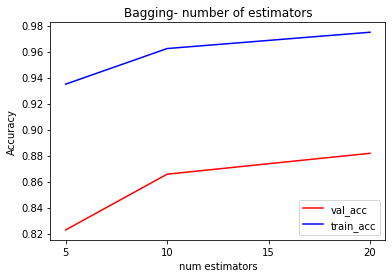

In [21]:
validate_model(xmr, ymr)

In [16]:
# prediction using rfe features
# model = build_model(xmr.shape[1])
model.fit(xmr,ymr) # in accuracy will work with both integer and float values between 0 to 1.
acc_mean_rfecv = accuracy_score(b[1], model.predict(rfecvmean.transform(a[1]))>=1/2 )*100

# model = build_model(xkr.shape[1])
model.fit(xkr, ykr)
acc_knn_rfecv = accuracy_score(b[3], model.predict(rfecvknn.transform(a[3]))>=1/2)*100

print(acc_mean_rfecv);
print(acc_knn_rfecv);

89.34010152284264
89.46700507614213


In [18]:
# prediction using eda features
# model = build_model(xme.shape[1])
model.fit(xme,yme)
acc_mean_eda = accuracy_score(b[3], model.predict(np.delete(a[3].copy(),list(eda_features_mean),axis=1))>=1/2)*100

# model = build_model(xke.shape[1])
model.fit(xke, yke)
acc_knn_eda = accuracy_score(b[3], model.predict(np.delete(a[3].copy(),list(eda_features_knn),axis=1))>=1/2)*100

print(acc_mean_eda);
print(acc_knn_eda);

89.72081218274111
89.78426395939087
